In [1]:
using ForneyLab, Random, LinearAlgebra, Plots, Flux.Optimise, DelimitedFiles, DataFrames
using ForneyLab: unsafeMean, unsafeCov

Random.seed!(1234);

# Dataset

In [2]:
sensors = readdlm("sensors.txt")
sensor1, sensor2, sensor3 = sensors[1,:], sensors[2,:], sensors[3,:]
observation = readdlm("observation.txt")
position = readdlm("position.txt")
# T = size(observation)[1]
T = 15
observation_list = []
for t=1:T
    push!(observation_list, observation[t,:])
end

# Model Specification

In [3]:
# Newtonian dynamics assumption
A = [1. 0. 1. 0.; 0. 1. 0. 1.; 0. 0. 1. 0.; 0. 0. 0. 1.]
B = [1. 0. 0. 0.; 0. 1. 0. 0.]
;

In [4]:
# Nonlinear function that maps states to observations
function f(z)       
    pos = B*z
    o1 = sqrt(sum((pos-sensor1).^2))
    o2 = sqrt(sum((pos-sensor2).^2))
    o3 = sqrt(sum((pos-sensor3).^2))
    o = [o1,o2,o3]
end

f (generic function with 1 method)

In [5]:
graph = FactorGraph()

W = diagm(0=>ones(4))
R = diagm(0=>ones(3))

z = Vector{Variable}(undef, T)
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

@RV z[1] ~ GaussianMeanVariance(zeros(4), diagm(0=>ones(4)))
@RV x[1] ~ Cvi(z[1],g=f,opt=Descent(0.1),num_samples=1000,num_iterations=100)
@RV y[1] ~ GaussianMeanPrecision(x[1],R)
placeholder(y[1], :y, dims=(3,), index=1)

for t=2:T
    @RV z[t] ~ GaussianMeanPrecision(A*z[t-1],W)
    @RV x[t] ~ Cvi(z[t],g=f,opt=Descent(0.1),num_samples=1000,num_iterations=100)
    @RV y[t] ~ GaussianMeanPrecision(x[t],R)
    placeholder(y[t], :y, dims=(3,), index=t)
end

In [6]:
# Specify factorizations in recognition distribution
pfz = PosteriorFactorization()

q_z = PosteriorFactor(z, id=:z)

algo_struct = messagePassingAlgorithm(id=:Struct, free_energy=true)

# Generate source code
code_struct = algorithmSourceCode(algo_struct, free_energy=true);

In [7]:
println(code_struct)

begin

function stepStructz!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 144))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0]), ProbabilityDistribution(MatrixVariate, PointMass, m=[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]))
messages[2] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Multivariate, PointMass, m=data[:y][1]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]))
messages[3] = ruleSPCVIIn1Factor(:cvi_1, messages[2], messages[1])
messages[4] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Multivariate, PointMass, m=data[:y][2]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]))
messages[5] = ruleSPCVIIn1Factor(:cvi_2, messages[4], messages[76])
messages[6] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Multiv

In [8]:
# Load algorithm
eval(Meta.parse(code_struct));

In [9]:
# Messages needs to be initiated for CVI
messages = Vector{Message}(undef, 194)
for i=1:194
    messages[i] = Message(Multivariate, GaussianMeanPrecision, m=zeros(4), w=0.01*diagm(0=>ones(4)))
end

In [10]:
n_its = 5
data = Dict(:y => observation_list)
marginals = Dict()

marginals[:R] = diagm(0=>ones(3))
marginals[:W] = diagm(0=>ones(4))

F = []
# Run algorithm
for i = 1:n_its
    stepStructz!(data, marginals, messages)
    push!(F, freeEnergyStruct(data, marginals))
end
;

In [11]:
F

5-element Array{Any,1}:
 95.08996427535132
 94.39953584285777
 94.42294988808554
 94.40710731722935
 94.78436558906198

In [12]:
# Collect the marginals
qz = [ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=unsafeMean(marginals[:z_1]), v=unsafeCov(marginals[:z_1]))]
for t=2:T
    k = t-1
    # variable refers to A*z_{t-1}
    qzₜ = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=unsafeMean(marginals[:z_*t*Symbol("_variable_")*k])[1:4], v=unsafeCov(marginals[:z_*t*Symbol("_variable_")*k])[1:4,1:4])
    push!(qz, qzₜ)
end

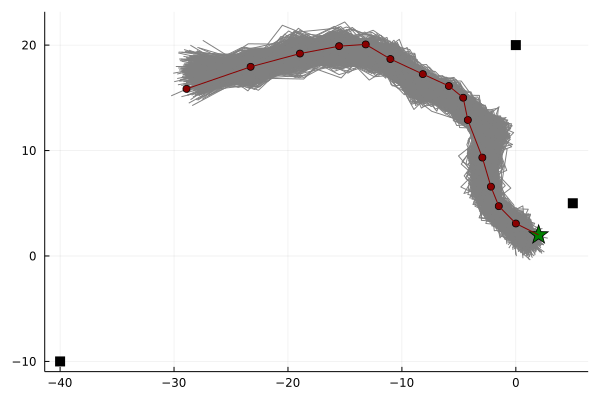

In [13]:
Estimations_samples = []
for s=1:1000
    Estimations = zeros(2,T)
    for t=1:T
        Estimations[:,t] = sample(qz[t])[1:2]
    end
    push!(Estimations_samples,Estimations)
end

plot(Estimations_samples[1][1,:],Estimations_samples[1][2,:],color=:grey, alfa=0.1)
for s=2:1000
    Estimations = Estimations_samples[s]
    plot!(Estimations[1,:],Estimations[2,:],color=:grey, alfa=0.1)
end
plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],seriestype = :scatter,color=:black, markersize=5, markershape=:square)
plot!(position[1,1:T],position[2,1:T], seriestype = :scatter,color=:redsblues)
scatter!((position[1,1],position[2,1]), color=:green, markershape=:star5, markersize=10)
plot!(position[1,1:T],position[2,1:T],color=:redsblues, legend=false)